In [1]:
from bs4 import BeautifulSoup
import requests
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import pandas as pd
import time
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException
from datetime import datetime
import calendar
import json
import csv
import numpy as np
from selenium import webdriver
import time
import math
import re
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

## Data Preparation

We will only keep the columns that we need.

In [2]:
gas_stations = pd.read_csv('[HUN_FUEL]04_23.csv')
gas_stations['Franchise (or private)'] = gas_stations['Franchise (or private)'].replace('Mobil Gáz', 'Magán')

In [3]:
gas_stations = gas_stations.loc[:, ~gas_stations.columns.isin(['1km','5km','10km','20km','30km','40km'])]
gas_stations.columns

Index(['Address with post code (Gas Stations)', 'Address', 'City', 'Post Code',
       'Franchise (or private)', 'Highway', 'Link', 'Services',
       'Address from website', '95-ös Benzin E10', 'Gázolaj', 'Lpg',
       '100-As Benzin E5', 'Cng', 'Prémium Gázolaj', 'Prémium Benzin E10',
       '98-As Benzin E5', 'Adblue', 'Type-1 Elektromos Töltő',
       'Type-2 Elektromos Töltő', 'Chademo Elektromos Töltő',
       'Ccs - Elektromos Töltő', 'Number of competition 1km',
       'Number of competition 5km', 'Number of competition 10km',
       'Number of competition 20km', 'Number of competition 30km',
       'Number of competition 40km', 'City_for_merge', 'Housing',
       'Retail stores', 'Unemployed 15-64', 'Allowance',
       'Income tax per person', 'Commuters Abroad', 'N drinking water',
       'Employed 15-64', 'Tax per 1000', 'N of cars per 1000',
       'N of agriculture', 'Commuter Difference', 'Income Tax per Person',
       'Locally Employed'],
      dtype='object')

In [4]:
gas_stations[['City', 'Post Code','Franchise (or private)', 'Highway']] = gas_stations[['City', 'Post Code','Franchise (or private)', 'Highway']].astype('category')

radius = ['Number of competition 1km','Number of competition 5km','Number of competition 10km','Number of competition 20km', 'Number of competition 30km', 'Number of competition 40km']
gas_stations[radius] = gas_stations[radius].astype('int')

## City Attribute:

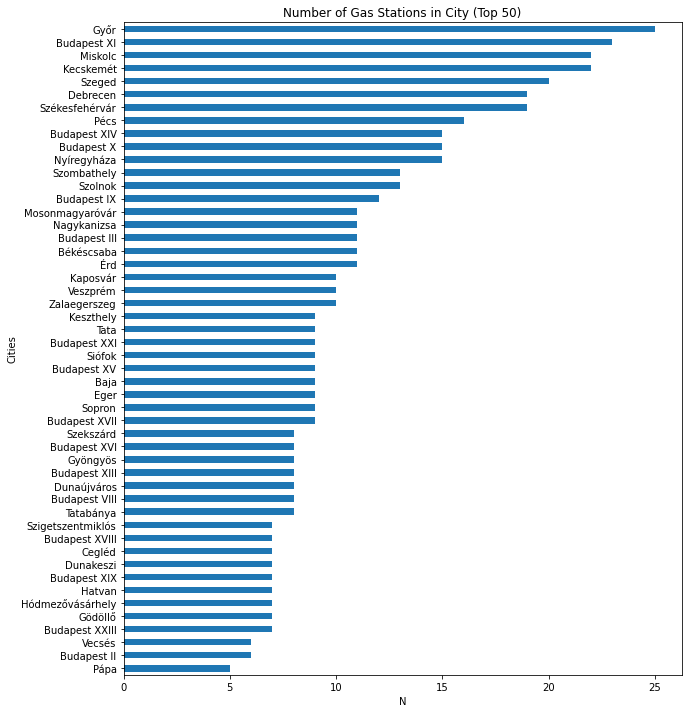

In [5]:
counts = gas_stations['City'].value_counts()[:50].sort_values(ascending = True)

plt.figure(figsize=(10, 12))
counts.plot(kind='barh')

plt.title('Number of Gas Stations in City (Top 50)')
plt.xlabel('N')
plt.ylabel('Cities')
plt.show()

We would like to check the relationship between the **City and Franchise** attribute. For independence we use Chi Squared test.

In [6]:
# Create a contingency table
cont_table = pd.crosstab(gas_stations['City'], gas_stations['Franchise (or private)'])

# Perform chi-squared test
chi2, p_value, dof, expected = chi2_contingency(cont_table)

print(f"Chi-square statistic for City and Franchise: {chi2}")
print(f"P-value: {p_value}")

Chi-square statistic for City and Franchise: 3657.8629274539476
P-value: 0.0012011102447612128


In this case, the chi-square statistic of 3657.86 is relatively large, and the small p-value of 0.0012 indicates strong evidence against the null hypothesis. Therefore, we can conclude that there is a significant association between City and Franchise (or private) status of gas stations

**City (and highway) and Gas Prices**: We will group by cities (and highway) and calculate the average prices. We should check where the best and worst prices are.

In [7]:
from IPython.display import display, HTML

gas_types = ['95-ös Benzin E10', 'Gázolaj', 'Lpg',
             '100-As Benzin E5', 'Prémium Gázolaj', 'Prémium Benzin E10',
             '98-As Benzin E5']

# create HTML and CSS for grid layout
html = "<style>.container { display: grid; grid-template-columns: repeat(5, 1fr); grid-gap: 20px; } </style>"
html += "<div class='container'>"

# loop through gas types and display top and worst 5 prices in a dataframe
for gas in gas_types:
    top_5 = gas_stations.groupby(['City', 'Highway'])[gas].mean().sort_values()[:5].to_frame()
    worst_5 = gas_stations.groupby(['City', 'Highway'])[gas].mean().sort_values(ascending = False)[:5].to_frame()
    
    # create HTML for each dataframe
    top_html = f"<h3>Top 5 Prices for {gas}</h3>{top_5.to_html()}"
    worst_html = f"<h3>Worst 5 Prices for {gas}</h3>{worst_5.to_html()}"
    
    # add HTML for each dataframe to the grid
    if gas == gas_types[-1]:
        html += f"<div>{top_html}</div><div>{worst_html}</div>"
    else:
        html += f"<div>{top_html}</div><div>{worst_html}</div>"

html += "</div>"

# display the grid
display(HTML(html))

,,95-ös Benzin E10
City,Highway,
Kisapostag,0,573.0
Hernád,0,573.0
Erdőkertes,0,577.0
Budakalász,0,579.0
Csömör,0,579.0
,,95-ös Benzin E10
City,Highway,
Akasztó,0,633.0
Bátaszék,1,628.9


## Franchise variable
We already checked the relationship between the City and Franchise variable.

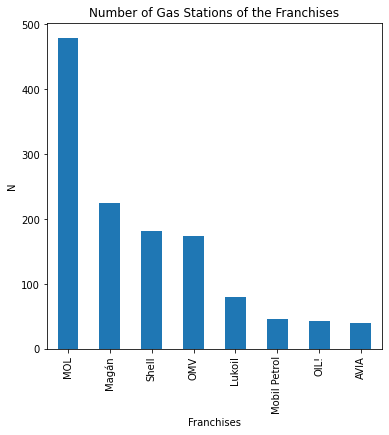

In [8]:
counts = gas_stations['Franchise (or private)'].value_counts()
plt.figure(figsize=(6, 6))
counts.plot(kind='bar')

plt.title('Number of Gas Stations of the Franchises')
plt.xlabel('Franchises')
plt.ylabel('N')
plt.show()

Next we should check the relationship between the Franchise and Highway attribute. We will use the same chi squared test.

In [9]:
cont_table = pd.crosstab(gas_stations['Franchise (or private)'], gas_stations['Highway'])

# Perform chi-squared test
chi2, p_value, dof, expected = chi2_contingency(cont_table)

print(f"Chi-square statistic for Franchise and Highway: {chi2}")
print(f"P-value: {p_value}")

Chi-square statistic for Franchise and Highway: 42.84128415553539
P-value: 3.579460471015146e-07


This means that there is a significant association between the franchise and highway attribute.

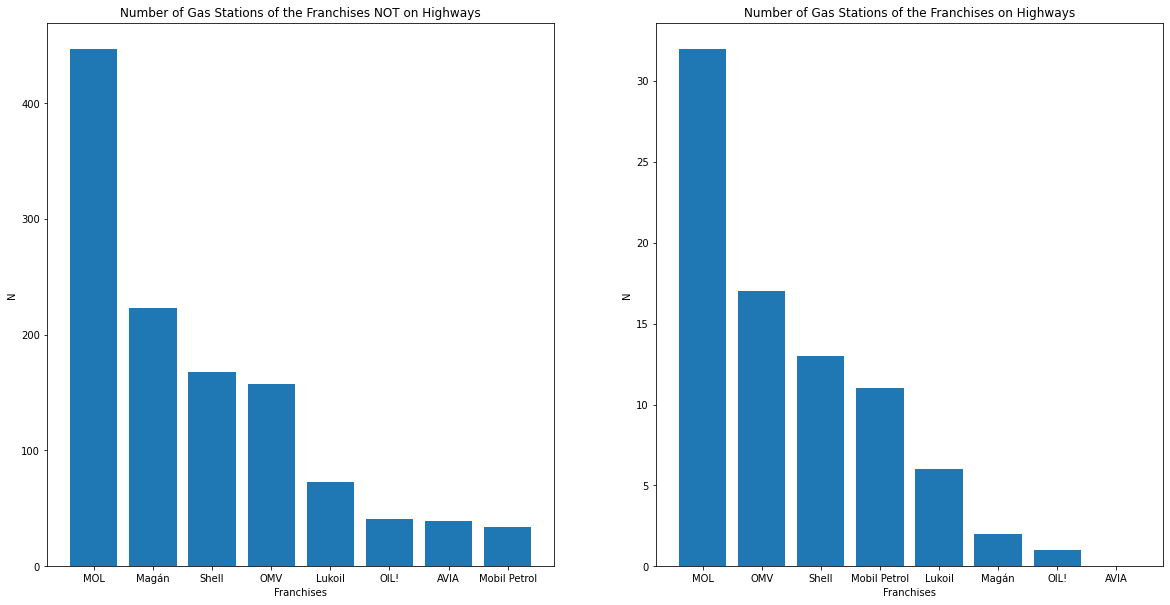

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Plot the first graph on the left subplot
not_on_highway = gas_stations.loc[gas_stations['Highway'] == 0]
counts_not = not_on_highway['Franchise (or private)'].value_counts()
axs[0].bar(counts_not.index, counts_not.values)
axs[0].set_title('Number of Gas Stations of the Franchises NOT on Highways')
axs[0].set_xlabel('Franchises')
axs[0].set_ylabel('N')

# Plot the second graph on the right subplot
on_highway = gas_stations.loc[gas_stations['Highway'] == 1]
counts = on_highway['Franchise (or private)'].value_counts()
axs[1].bar(counts.index, counts.values)
axs[1].set_title('Number of Gas Stations of the Franchises on Highways')
axs[1].set_xlabel('Franchises')
axs[1].set_ylabel('N')

# Show the plot
plt.show()

The average Price based on Franchise:

In [11]:
gas_stations.groupby(['Franchise (or private)'])[['95-ös Benzin E10', 'Gázolaj', 'Lpg',
       '100-As Benzin E5', 'Prémium Gázolaj', 'Prémium Benzin E10',
       '98-As Benzin E5', 'Adblue']].mean()

,95-ös Benzin E10,Gázolaj,Lpg,100-As Benzin E5,Prémium Gázolaj,Prémium Benzin E10,98-As Benzin E5,Adblue
Franchise (or private),,,,,,,,
AVIA,597.581250,580.076471,369.250000,633.616667,618.077778,NaN,NaN,541.000000
Lukoil,592.544304,572.645570,361.333333,623.642857,604.957447,NaN,NaN,NaN
MOL,593.308102,577.256223,354.482412,636.375701,632.360092,629.000000,NaN,586.000000
Magán,588.183784,568.445752,344.582759,627.351852,609.555769,619.212500,612.086957,456.785106
Mobil Petrol,586.122222,567.211111,340.904762,616.534146,608.157143,627.900000,NaN,599.039130
OIL!,595.082143,575.480000,389.257143,649.737500,598.300000,607.942857,683.450000,458.386667
OMV,601.581595,578.197576,350.130769,641.800000,633.330061,626.136842,NaN,529.933333
Shell,594.297790,577.667956,400.900000,669.072414,643.240000,625.060000,NaN,NaN


The average Price based on Franchise and Highway:

In [12]:
gas_stations.groupby(['Franchise (or private)', 'Highway'])[['95-ös Benzin E10', 'Gázolaj', 'Lpg',
       '100-As Benzin E5', 'Prémium Gázolaj', 'Prémium Benzin E10',
       '98-As Benzin E5', 'Adblue']].mean()

95-ös Benzin E10     Gázolaj         Lpg  \
Franchise (or private) Highway                                             
AVIA                   0              597.581250  580.076471  369.250000   
                       1                     NaN         NaN         NaN   
Lukoil                 0              591.000000  571.000000  356.000000   
                       1              611.333333  592.666667  380.000000   
MOL                    0              592.076659  576.012442  352.527778   
                       1              610.125000  594.125000  373.000000   
Magán                  0              588.110884  568.300000  344.582759   
                       1              598.900000  579.450000         NaN   
Mobil Petrol           0              581.841176  562.164706  339.000000   
                       1              599.354545  582.809091  347.000000   
OIL!                   0              595.082143  575.480000  389.257143   
                       1                     NaN         NaN         NaN   
OMV                    0              598.743151  575.961486  350.130769   
                       1              625.958824  597.664706         NaN   
Shell                  0              592.084524  575.715476         NaN   
                       1              622.900000  602.900000  400.900000   

                                100-As Benzin E5  Prémium Gázolaj  \
Franchise (or private) Highway                                      
AVIA                   0              633.616667       618.077778   
                       1                     NaN              NaN   
Lukoil                 0              621.000000       601.000000   
                       1              645.666667       632.000000   
MOL                    0              635.022166       631.032178   
                       1              653.709677       649.125000   
Magán                  0              627.133962       609.137255   
                       1              638.900000       630.900000   
Mobil Petrol           0              611.833333       601.441667   
                       1              629.354545       622.809091   
OIL!                   0              649.737500       598.300000   
                       1                     NaN              NaN   
OMV                    0              638.837324       631.010274   
                       1              666.547059       653.252941   
Shell                  0              667.067702       640.900000   
                       1              693.900000       667.900000   

                                Prémium Benzin E10  98-As Benzin E5  \
Franchise (or private) Highway                                        
AVIA                   0                       NaN              NaN   
                       1                       NaN              NaN   
Lukoil                 0                       NaN              NaN   
                       1                       NaN              NaN   
MOL                    0                629.000000              NaN   
                       1                       NaN              NaN   
Magán                  0                618.685714       612.086957   
                       1                622.900000              NaN   
Mobil Petrol           0                       NaN              NaN   
                       1                627.900000              NaN   
OIL!                   0                607.942857       683.450000   
                       1                       NaN              NaN   
OMV                    0                622.914815              NaN   
                       1                651.723529              NaN   
Shell                  0                622.900000              NaN   
                       1                649.900000              NaN   

                                    Adblue  
Franchise (or private) Highway              
AVIA                   0        541.000000  
      

Franchises and their standard deviations:

In [13]:
gas_stations.groupby('Franchise (or private)')[['95-ös Benzin E10', 'Gázolaj', 'Lpg',
       '100-As Benzin E5', 'Prémium Gázolaj', 'Prémium Benzin E10',
       '98-As Benzin E5', 'Adblue']].std()

,95-ös Benzin E10,Gázolaj,Lpg,100-As Benzin E5,Prémium Gázolaj,Prémium Benzin E10,98-As Benzin E5,Adblue
Franchise (or private),,,,,,,,
AVIA,7.615179,13.599565,53.356505,11.387779,24.169649,NaN,NaN,87.939915
Lukoil,5.422644,5.813419,10.267023,8.000974,10.836648,NaN,NaN,NaN
MOL,5.903380,5.769308,7.581773,6.196401,5.088293,NaN,NaN,71.042241
Magán,8.121945,9.550765,38.063885,12.819513,16.038403,9.731163,7.354115,131.995631
Mobil Petrol,9.593769,11.224612,6.015852,9.964327,12.322487,0.000000,NaN,0.187663
OIL!,8.340621,20.672444,63.373440,32.555137,5.173973,10.606736,61.589001,82.630407
OMV,8.882736,6.952890,15.690271,8.961387,7.036265,9.175072,NaN,287.980908
Shell,8.304403,7.761105,NaN,7.365294,7.621790,7.354393,NaN,NaN


Next we should check out the average competitions of given radius of the franchises.

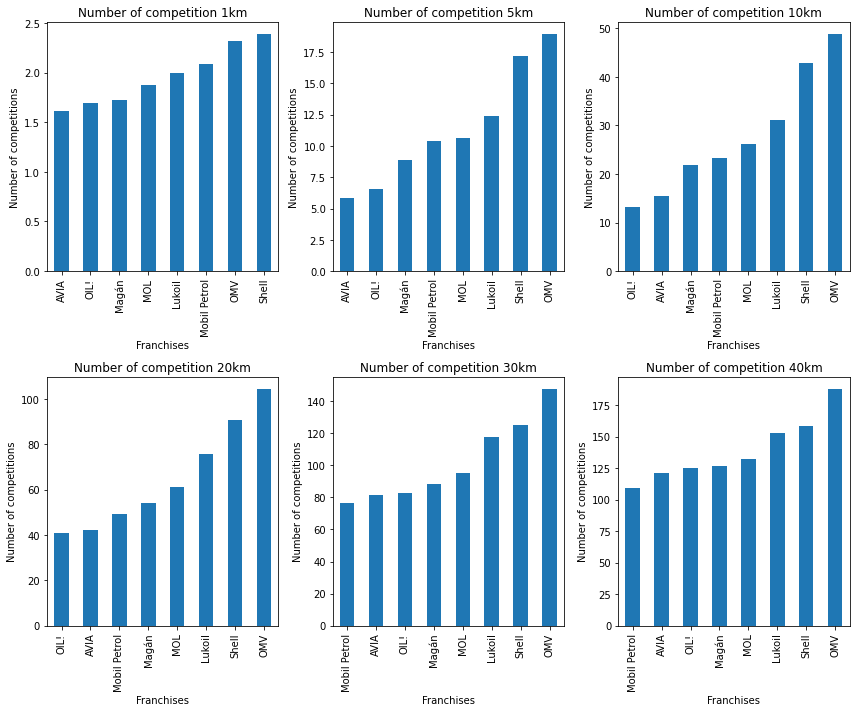

In [14]:
radius = ['Number of competition 1km','Number of competition 5km','Number of competition 10km','Number of competition 20km', 'Number of competition 30km', 'Number of competition 40km']
mean_competitions = gas_stations.groupby('Franchise (or private)')[radius].mean()

# create the subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,10))

# flatten the axes array for easier iteration
axes = axes.flatten()

# iterate over the columns and plot each one
for i, col in enumerate(mean_competitions.columns):
    ax = axes[i]
    mean_competitions[col].sort_values().plot(kind='bar', ax=ax)
    ax.set_title(col)
    ax.set_xlabel('Franchises')
    ax.set_ylabel('Number of competitions')
    
    
# adjust the layout and show the plot
plt.tight_layout()
plt.show()

## Highway Column

In [15]:
gas_stations.groupby('Highway')[['95-ös Benzin E10', 'Gázolaj', 'Lpg',
       '100-As Benzin E5', 'Prémium Gázolaj', 'Prémium Benzin E10',
       '98-As Benzin E5', 'Adblue', 'Type-1 Elektromos Töltő',
       'Type-2 Elektromos Töltő', 'Chademo Elektromos Töltő',
       'Ccs - Elektromos Töltő']].mean()

,95-ös Benzin E10,Gázolaj,Lpg,100-As Benzin E5,Prémium Gázolaj,Prémium Benzin E10,98-As Benzin E5,Adblue,Type-1 Elektromos Töltő,Type-2 Elektromos Töltő,Chademo Elektromos Töltő,Ccs - Elektromos Töltő
Highway,,,,,,,,,,,,
0,592.207531,574.111374,352.032971,639.696366,628.671166,622.424151,617.796,490.625287,89.0,94.0,89.0,NaN
1,614.035000,594.269136,370.444828,658.896203,647.922500,647.275000,NaN,592.833333,NaN,119.0,119.0,119.0


This clearly shows that the prices are higher next to Highways, also there is significant difference in standard deviations.

In [16]:
gas_stations.groupby('Highway')[['95-ös Benzin E10', 'Gázolaj', 'Lpg',
       '100-As Benzin E5', 'Prémium Gázolaj', 'Prémium Benzin E10',
       '98-As Benzin E5', 'Adblue', 'Type-1 Elektromos Töltő',
       'Type-2 Elektromos Töltő', 'Chademo Elektromos Töltő',
       'Ccs - Elektromos Töltő']].std()

,95-ös Benzin E10,Gázolaj,Lpg,100-As Benzin E5,Prémium Gázolaj,Prémium Benzin E10,98-As Benzin E5,Adblue,Type-1 Elektromos Töltő,Type-2 Elektromos Töltő,Chademo Elektromos Töltő,Ccs - Elektromos Töltő
Highway,,,,,,,,,,,,
0,5.577874,6.882271,18.984251,15.477459,11.843314,3.367562,24.455376,127.074724,NaN,21.213203,NaN,NaN
1,11.262080,8.906706,12.880040,20.184905,14.998033,9.293598,NaN,21.361960,NaN,NaN,NaN,NaN


## 'Correlation' between the categorical variables:

Cramer's V is a measure of association between two categorical variables and ranges from 0 to 1, where 0 indicates no association and 1 indicates a strong association.

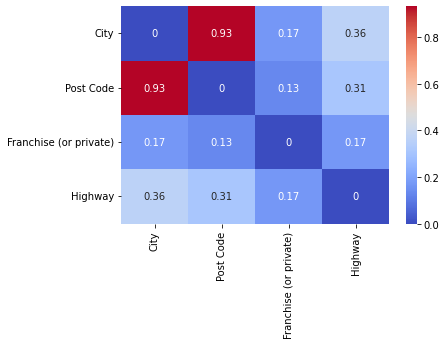

In [17]:
cat_val = gas_stations[['City', 'Post Code', 'Franchise (or private)', 'Highway']]

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2_corrected = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    r_corrected = r - ((r-1)**2)/(n-1)
    k_corrected = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2_corrected/min((k_corrected-1),(r_corrected-1)))

# create an empty correlation matrix
corr_matrix = pd.DataFrame(np.zeros((len(cat_val.columns), len(cat_val.columns))), columns=cat_val.columns, index=cat_val.columns)

# compute Cramer's V for each pair of columns
for i in range(len(cat_val.columns)):
    for j in range(i+1, len(cat_val.columns)):
        v = cramers_v(cat_val.iloc[:, i], cat_val.iloc[:, j])
        corr_matrix.iloc[i, j] = v
        corr_matrix.iloc[j, i] = v

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

## Correlation on Numerical Variables:

/tmp/ipykernel_4554/3550974338.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = float_val.corr()


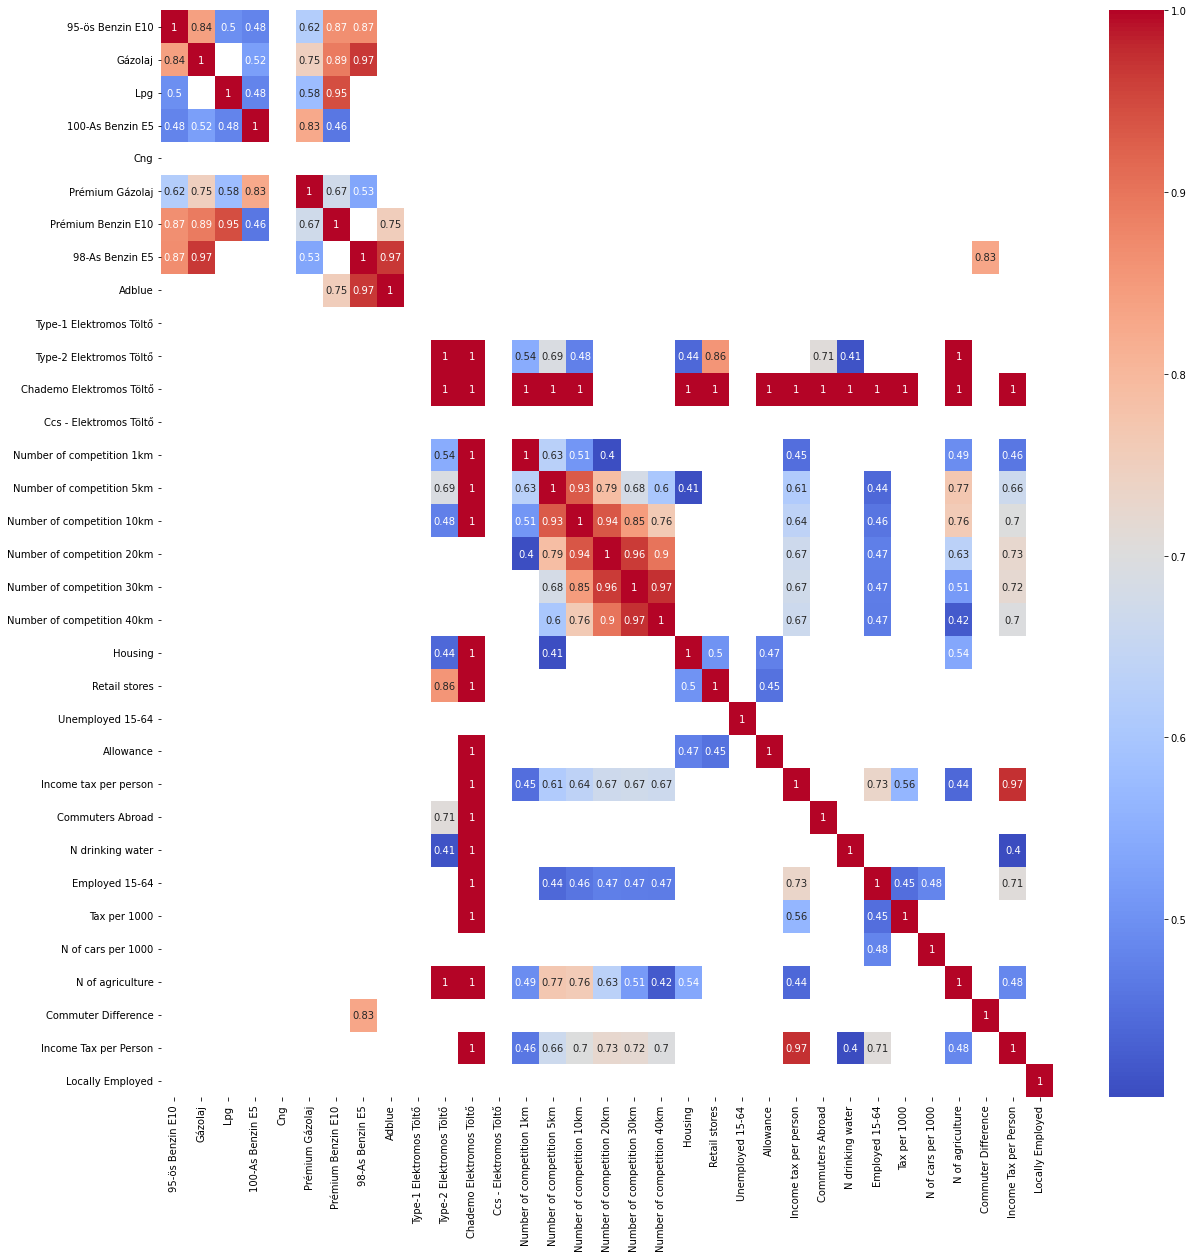

In [18]:
float_val = gas_stations.loc[:, ~gas_stations.columns.isin(cat_val)]
corr = float_val.corr()
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm',mask=(corr <= 0.4))

# Show the plot
plt.show()

## Price Attributes:

In [19]:
prices = ['95-ös Benzin E10', 'Gázolaj', 'Lpg', '100-As Benzin E5',
       'Prémium Gázolaj', 'Prémium Benzin E10', '98-As Benzin E5', 'Adblue',
        'Type-2 Elektromos Töltő',
       'Chademo Elektromos Töltő']

gas_stations[prices].describe()

,95-ös Benzin E10,Gázolaj,Lpg,100-As Benzin E5,Prémium Gázolaj,Prémium Benzin E10,98-As Benzin E5,Adblue,Type-2 Elektromos Töltő,Chademo Elektromos Töltő
count,1129.000000,1136.000000,305.000000,932.000000,895.000000,297.000000,25.000000,99.000000,3.000000,2.000000
mean,593.754207,575.548680,353.783607,641.323820,630.391955,625.101684,617.796000,503.014141,102.333333,104.000000
std,8.317731,8.746862,19.250061,16.792511,13.333790,8.873017,24.455376,123.879028,20.816660,21.213203
min,569.900000,548.000000,306.000000,599.900000,574.000000,595.900000,607.000000,280.000000,79.000000,89.000000
25%,591.900000,575.900000,349.900000,635.000000,630.900000,622.900000,609.000000,399.000000,94.000000,96.500000
50%,592.000000,575.900000,353.000000,635.000000,631.000000,622.900000,609.000000,520.000000,109.000000,104.000000
75%,592.900000,576.000000,353.000000,647.000000,631.000000,622.900000,609.000000,599.000000,114.000000,111.500000
max,633.000000,680.000000,490.000000,728.000000,667.900000,652.900000,727.000000,860.000000,119.000000,119.000000


As we can see we have fresh data, since there are no 480 priced minimum.

## Number of competitions in radius:

Here we will check basic statistics about these attributes.

In [20]:
comp = ['Number of competition 1km', 'Number of competition 5km',
       'Number of competition 10km', 'Number of competition 20km',
       'Number of competition 30km', 'Number of competition 40km']
gas_stations[comp].describe()

,Number of competition 1km,Number of competition 5km,Number of competition 10km,Number of competition 20km,Number of competition 30km,Number of competition 40km
count,1264.000000,1264.000000,1264.000000,1264.000000,1264.000000,1264.000000
mean,1.984968,12.238924,30.348892,69.357595,105.350475,142.650316
std,1.234473,16.334679,44.859534,90.238131,112.456335,123.643344
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,2.000000,5.000000,16.000000,35.000000,57.000000
50%,2.000000,5.000000,11.000000,27.000000,47.000000,77.000000
75%,3.000000,15.250000,24.000000,41.250000,151.250000,305.000000
max,6.000000,72.000000,167.000000,273.000000,321.000000,379.000000


## Number of competitions and Gas Prices plots:

### 1 km radius competition price change:

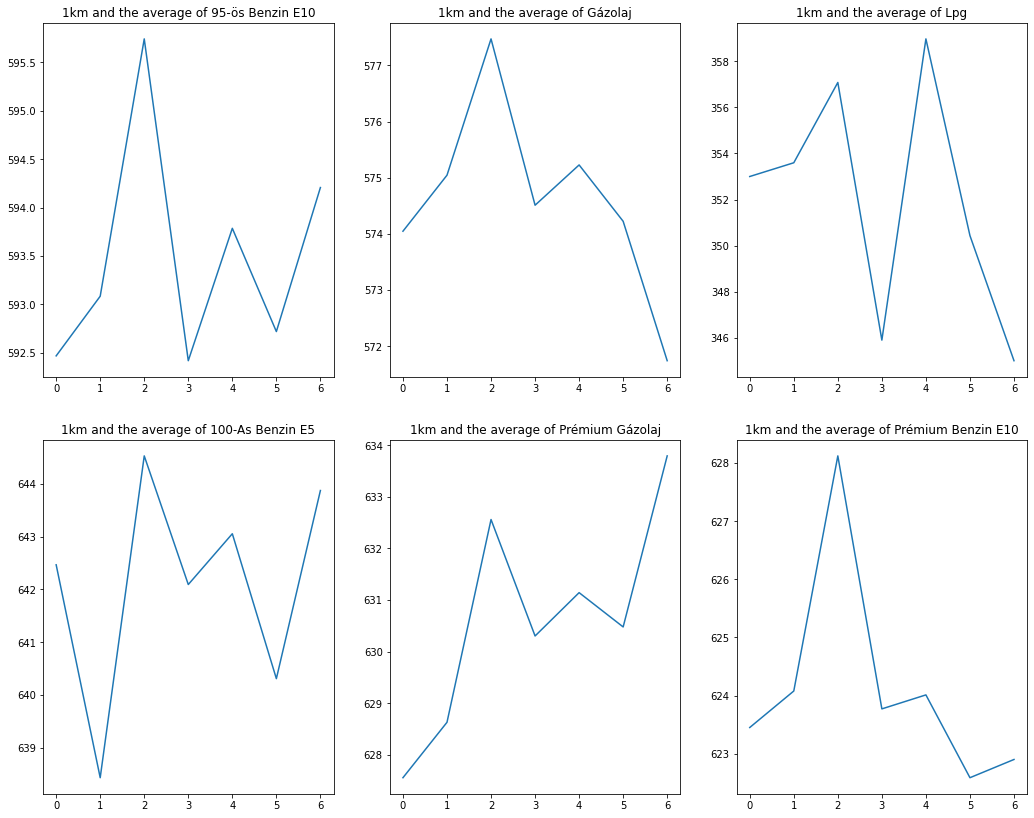

In [21]:
comp = ['Number of competition 1km', 'Number of competition 5km', 'Number of competition 10km', 'Number of competition 20km','Number of competition 30km', 'Number of competition 40km']

fuel_types = ['95-ös Benzin E10', 'Gázolaj', 'Lpg', '100-As Benzin E5', 'Prémium Gázolaj', 'Prémium Benzin E10', '98-As Benzin E5', 'Adblue']

fig, axs = plt.subplots(2, 3, figsize=(15, 12))

x = gas_stations[comp[0]].sort_values().unique()
y1 = gas_stations.groupby(comp[0])[fuel_types[0]].mean()
y2 = gas_stations.groupby(comp[0])[fuel_types[1]].mean()
y3 = gas_stations.groupby(comp[0])[fuel_types[2]].mean()
y4 = gas_stations.groupby(comp[0])[fuel_types[3]].mean()
y5 = gas_stations.groupby(comp[0])[fuel_types[4]].mean()
y6 = gas_stations.groupby(comp[0])[fuel_types[5]].mean()

axs[0, 0].plot(x, y1)
axs[0, 0].set_title(f'{comp[0][-3:]} and the average of {fuel_types[0]}')
axs[0, 1].plot(x, y2)
axs[0, 1].set_title(f'{comp[0][-3:]} and the average of {fuel_types[1]}')
axs[0, 2].plot(x, y3)
axs[0, 2].set_title(f'{comp[0][-3:]} and the average of {fuel_types[2]}')
axs[1, 0].plot(x, y4)
axs[1, 0].set_title(f'{comp[0][-3:]} and the average of {fuel_types[3]}')
axs[1, 1].plot(x, y5)
axs[1, 1].set_title(f'{comp[0][-3:]} and the average of {fuel_types[4]}')
axs[1, 2].plot(x, y6)
axs[1, 2].set_title(f'{comp[0][-3:]} and the average of {fuel_types[5]}')
plt.tight_layout(pad=3.0)
plt.show()

### 5 km radius competition price change:

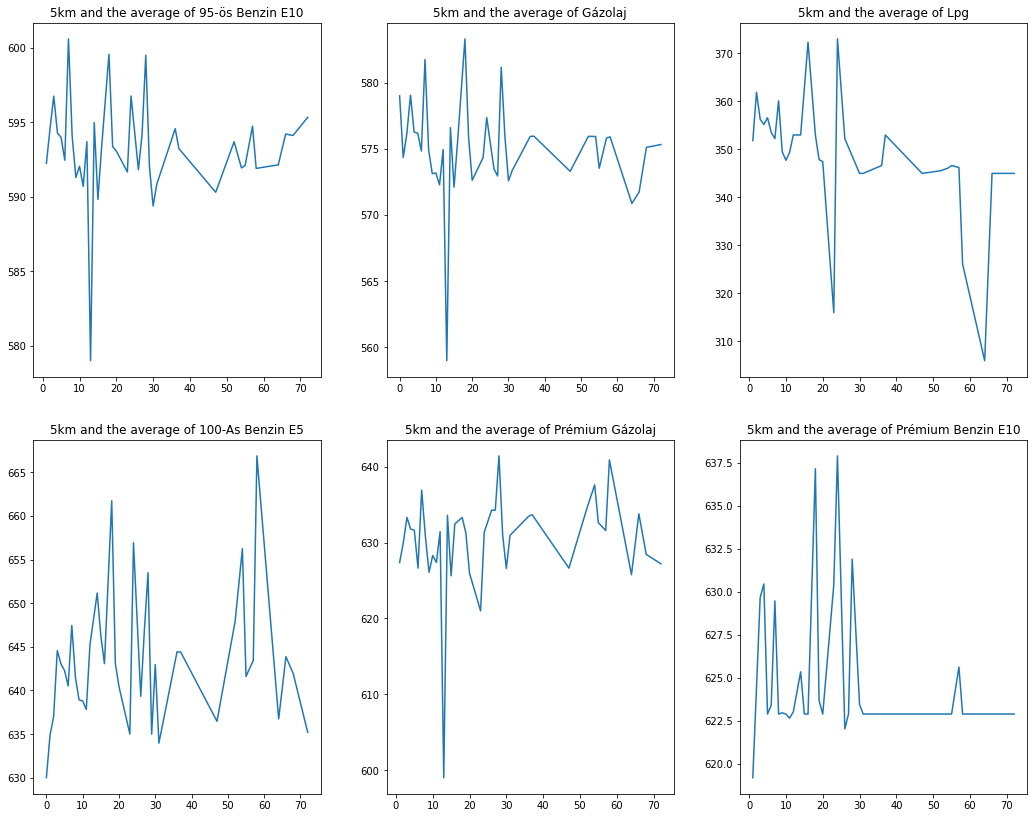

In [22]:
fig, axs = plt.subplots(2, 3, figsize=(15, 12))

x = gas_stations[comp[1]].sort_values().unique()
y1 = gas_stations.groupby(comp[1])[fuel_types[0]].mean().interpolate(method='linear')
y2 = gas_stations.groupby(comp[1])[fuel_types[1]].mean().interpolate(method='linear')
y3 = gas_stations.groupby(comp[1])[fuel_types[2]].mean().interpolate(method='linear')
y4 = gas_stations.groupby(comp[1])[fuel_types[3]].mean().interpolate(method='linear')
y5 = gas_stations.groupby(comp[1])[fuel_types[4]].mean().interpolate(method='linear')
y6 = gas_stations.groupby(comp[1])[fuel_types[5]].mean().interpolate(method='linear')

axs[0, 0].plot(x, y1)
axs[0, 0].set_title(f'{comp[1][-3:]} and the average of {fuel_types[0]}')
axs[0, 1].plot(x, y2)
axs[0, 1].set_title(f'{comp[1][-3:]} and the average of {fuel_types[1]}')
axs[0, 2].plot(x, y3)
axs[0, 2].set_title(f'{comp[1][-3:]} and the average of {fuel_types[2]}')
axs[1, 0].plot(x, y4)
axs[1, 0].set_title(f'{comp[1][-3:]} and the average of {fuel_types[3]}')
axs[1, 1].plot(x, y5)
axs[1, 1].set_title(f'{comp[1][-3:]} and the average of {fuel_types[4]}')
axs[1, 2].plot(x, y6)
axs[1, 2].set_title(f'{comp[1][-3:]} and the average of {fuel_types[5]}')
plt.tight_layout(pad=3.0)
plt.show()

### 10 km radius competition price change:

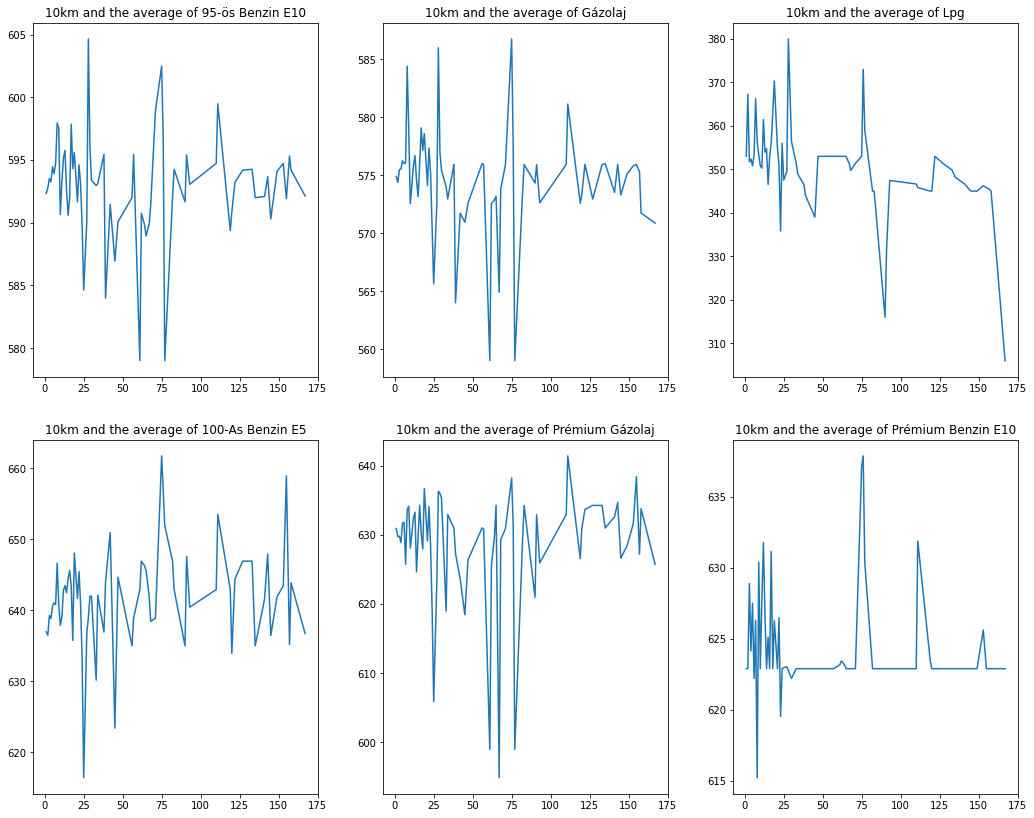

In [23]:
fig, axs = plt.subplots(2, 3, figsize=(15, 12))

x = gas_stations[comp[2]].sort_values().unique()
y1 = gas_stations.groupby(comp[2])[fuel_types[0]].mean().interpolate(method='linear')
y2 = gas_stations.groupby(comp[2])[fuel_types[1]].mean().interpolate(method='linear')
y3 = gas_stations.groupby(comp[2])[fuel_types[2]].mean().interpolate(method='linear')
y4 = gas_stations.groupby(comp[2])[fuel_types[3]].mean().interpolate(method='linear')
y5 = gas_stations.groupby(comp[2])[fuel_types[4]].mean().interpolate(method='linear')
y6 = gas_stations.groupby(comp[2])[fuel_types[5]].mean().interpolate(method='linear')

axs[0, 0].plot(x, y1)
axs[0, 0].set_title(f'{comp[2][-4:]} and the average of {fuel_types[0]}')
axs[0, 1].plot(x, y2)
axs[0, 1].set_title(f'{comp[2][-4:]} and the average of {fuel_types[1]}')
axs[0, 2].plot(x, y3)
axs[0, 2].set_title(f'{comp[2][-4:]} and the average of {fuel_types[2]}')
axs[1, 0].plot(x, y4)
axs[1, 0].set_title(f'{comp[2][-4:]} and the average of {fuel_types[3]}')
axs[1, 1].plot(x, y5)
axs[1, 1].set_title(f'{comp[2][-4:]} and the average of {fuel_types[4]}')
axs[1, 2].plot(x, y6)
axs[1, 2].set_title(f'{comp[2][-4:]} and the average of {fuel_types[5]}')
plt.tight_layout(pad=3.0)
plt.show()

### 20 km radius competition price change:

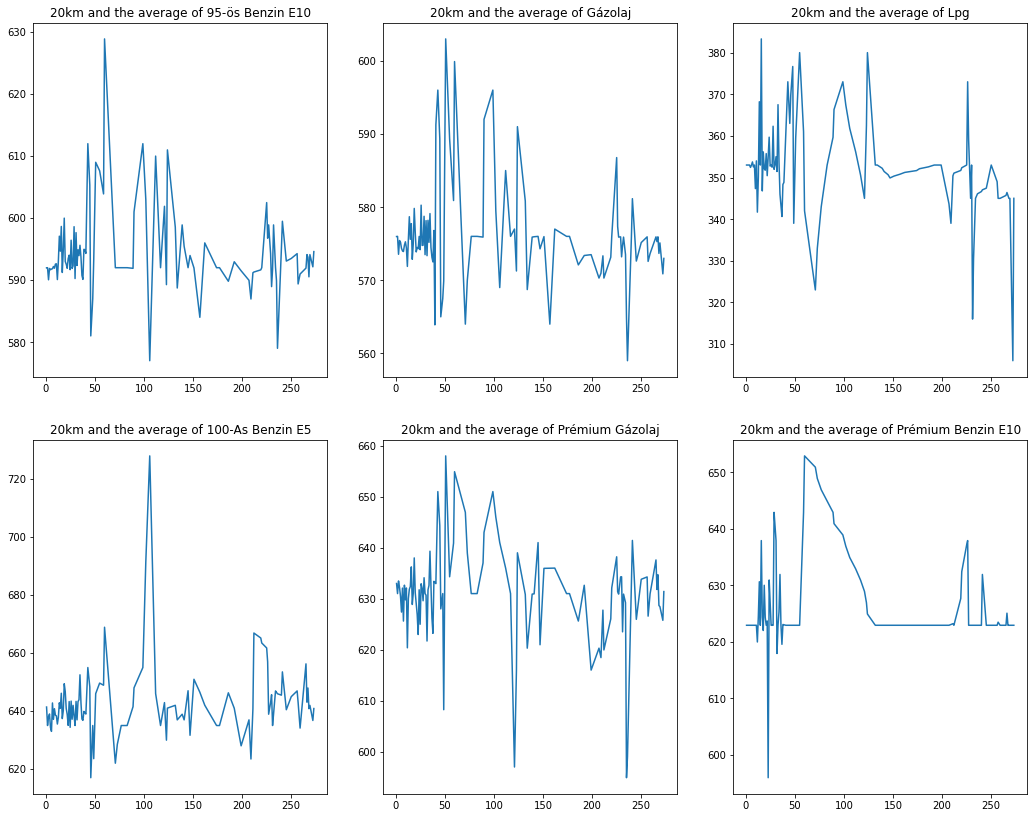

In [24]:
fig, axs = plt.subplots(2, 3, figsize=(15, 12))

x = gas_stations[comp[3]].sort_values().unique()
y1 = gas_stations.groupby(comp[3])[fuel_types[0]].mean().interpolate(method='linear')
y2 = gas_stations.groupby(comp[3])[fuel_types[1]].mean().interpolate(method='linear')
y3 = gas_stations.groupby(comp[3])[fuel_types[2]].mean().interpolate(method='linear')
y4 = gas_stations.groupby(comp[3])[fuel_types[3]].mean().interpolate(method='linear')
y5 = gas_stations.groupby(comp[3])[fuel_types[4]].mean().interpolate(method='linear')
y6 = gas_stations.groupby(comp[3])[fuel_types[5]].mean().interpolate(method='linear')

axs[0, 0].plot(x, y1)
axs[0, 0].set_title(f'{comp[3][-4:]} and the average of {fuel_types[0]}')
axs[0, 1].plot(x, y2)
axs[0, 1].set_title(f'{comp[3][-4:]} and the average of {fuel_types[1]}')
axs[0, 2].plot(x, y3)
axs[0, 2].set_title(f'{comp[3][-4:]} and the average of {fuel_types[2]}')
axs[1, 0].plot(x, y4)
axs[1, 0].set_title(f'{comp[3][-4:]} and the average of {fuel_types[3]}')
axs[1, 1].plot(x, y5)
axs[1, 1].set_title(f'{comp[3][-4:]} and the average of {fuel_types[4]}')
axs[1, 2].plot(x, y6)
axs[1, 2].set_title(f'{comp[3][-4:]} and the average of {fuel_types[5]}')
plt.tight_layout(pad=3.0)
plt.show()

### 30 km radius competition price change:

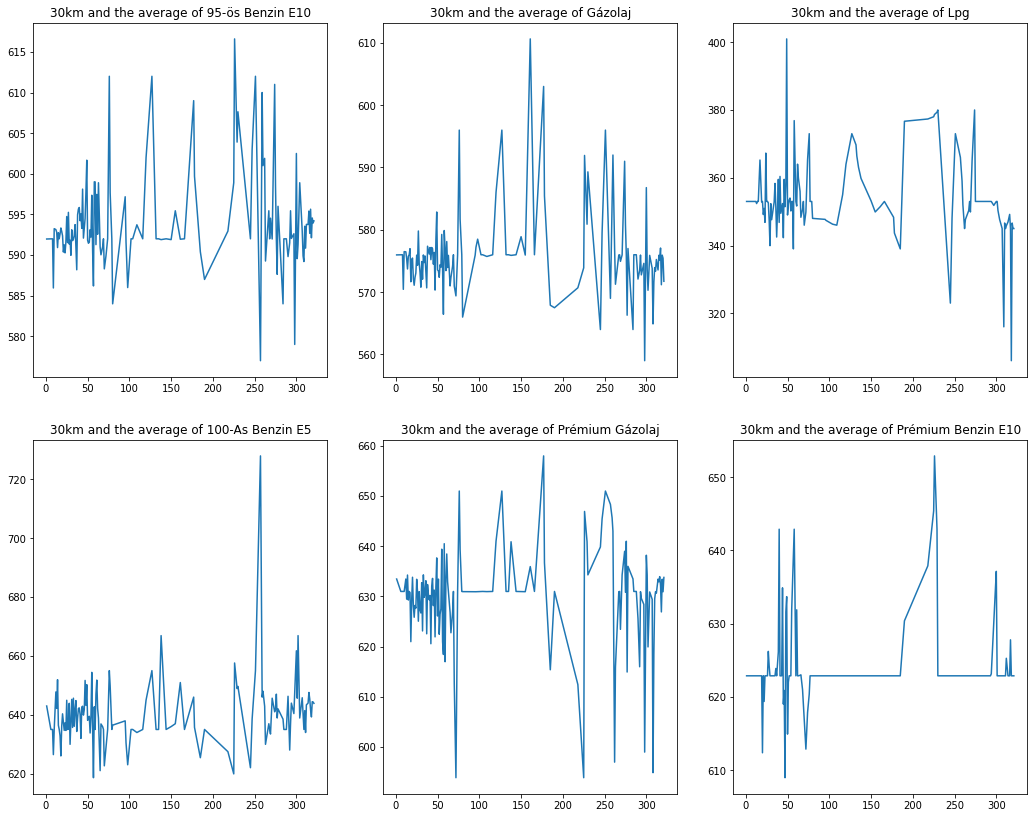

In [25]:
fig, axs = plt.subplots(2, 3, figsize=(15, 12))

x = gas_stations[comp[4]].sort_values().unique()
y1 = gas_stations.groupby(comp[4])[fuel_types[0]].mean().interpolate(method='linear')
y2 = gas_stations.groupby(comp[4])[fuel_types[1]].mean().interpolate(method='linear')
y3 = gas_stations.groupby(comp[4])[fuel_types[2]].mean().interpolate(method='linear')
y4 = gas_stations.groupby(comp[4])[fuel_types[3]].mean().interpolate(method='linear')
y5 = gas_stations.groupby(comp[4])[fuel_types[4]].mean().interpolate(method='linear')
y6 = gas_stations.groupby(comp[4])[fuel_types[5]].mean().interpolate(method='linear')

axs[0, 0].plot(x, y1)
axs[0, 0].set_title(f'{comp[4][-4:]} and the average of {fuel_types[0]}')
axs[0, 1].plot(x, y2)
axs[0, 1].set_title(f'{comp[4][-4:]} and the average of {fuel_types[1]}')
axs[0, 2].plot(x, y3)
axs[0, 2].set_title(f'{comp[4][-4:]} and the average of {fuel_types[2]}')
axs[1, 0].plot(x, y4)
axs[1, 0].set_title(f'{comp[4][-4:]} and the average of {fuel_types[3]}')
axs[1, 1].plot(x, y5)
axs[1, 1].set_title(f'{comp[4][-4:]} and the average of {fuel_types[4]}')
axs[1, 2].plot(x, y6)
axs[1, 2].set_title(f'{comp[4][-4:]} and the average of {fuel_types[5]}')
plt.tight_layout(pad=3.0)
plt.show()

### 40 km radius competition price change:

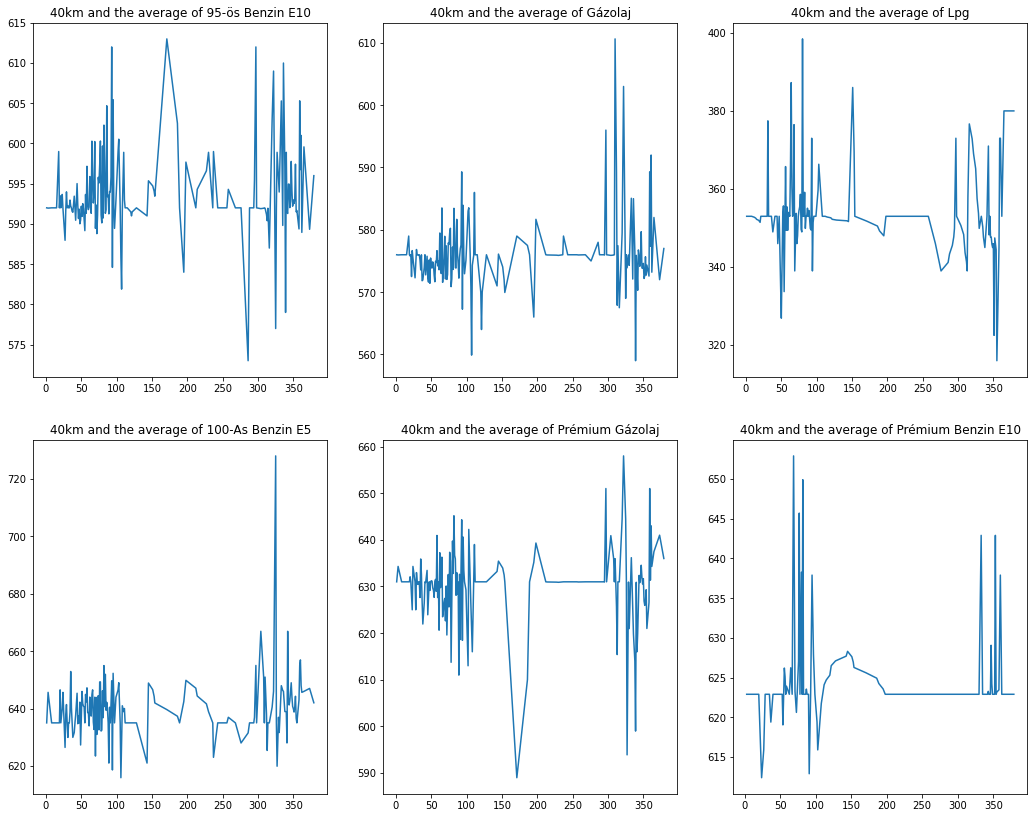

In [26]:
fig, axs = plt.subplots(2, 3, figsize=(15, 12))

x = gas_stations[comp[5]].sort_values().unique()
y1 = gas_stations.groupby(comp[5])[fuel_types[0]].mean().interpolate(method='linear')
y2 = gas_stations.groupby(comp[5])[fuel_types[1]].mean().interpolate(method='linear')
y3 = gas_stations.groupby(comp[5])[fuel_types[2]].mean().interpolate(method='linear')
y4 = gas_stations.groupby(comp[5])[fuel_types[3]].mean().interpolate(method='linear')
y5 = gas_stations.groupby(comp[5])[fuel_types[4]].mean().interpolate(method='linear')
y6 = gas_stations.groupby(comp[5])[fuel_types[5]].mean().interpolate(method='linear')

axs[0, 0].plot(x, y1)
axs[0, 0].set_title(f'{comp[5][-4:]} and the average of {fuel_types[0]}')
axs[0, 1].plot(x, y2)
axs[0, 1].set_title(f'{comp[5][-4:]} and the average of {fuel_types[1]}')
axs[0, 2].plot(x, y3)
axs[0, 2].set_title(f'{comp[5][-4:]} and the average of {fuel_types[2]}')
axs[1, 0].plot(x, y4)
axs[1, 0].set_title(f'{comp[5][-4:]} and the average of {fuel_types[3]}')
axs[1, 1].plot(x, y5)
axs[1, 1].set_title(f'{comp[5][-4:]} and the average of {fuel_types[4]}')
axs[1, 2].plot(x, y6)
axs[1, 2].set_title(f'{comp[5][-4:]} and the average of {fuel_types[5]}')
plt.tight_layout(pad=3.0)
plt.show()

## Analyzing County (megye in hungarian) Prices:

Check out the following link: https://irányítószámok.cybo.com/magyarorsz%C3%A1g/

In [27]:
def get_region(zip_code):
    if 1011 <= zip_code <= 1806:
        return 'Budapest'
    elif 2000 <= zip_code <= 2769:
        return 'Pest megye'
    elif (2400 <= zip_code <= 2490) or (8000 <= zip_code <= 8157):
        return 'Fejér megye'
    elif (2500 <= zip_code <= 2545) or (2800 <= zip_code <= 2949):
        return 'Komárom-Esztergom megye'
    elif (2640 <= zip_code <= 2699) or (3041 <= zip_code <= 3253):
        return 'Nógrád megye'
    elif (3000 <= zip_code <= 3036) or (3200 <= zip_code <= 3399):
        return 'Heves megye'
    elif 3400 <= zip_code <= 3999:
        return 'Borsod-Abaúj-Zemplén megye'
    elif 4000 <= zip_code <= 4288:
        return 'Hajdú-Bihar megye'
    elif (4300 <= zip_code <= 4977):
        return 'Szabolcs-Szatmár-Bereg megye'
    elif (5000 <= zip_code <= 5476):
        return 'Jász-Nagykun-Szolnok megye'
    elif (5500 <= zip_code <= 5948):
        return 'Békés megye'
    elif (6000 <= zip_code <= 6528):
        return 'Bács-Kiskun megye'
    elif (6600 <= zip_code <= 6932):
        return 'Csongrád vármegye'
    elif (7020 <= zip_code <= 7228):
        return 'Tolna megye'
    elif (7300 <= zip_code <= 7396) or (7600 <= zip_code <= 7985):
        return 'Baranya megye'
    elif (7400 <= zip_code <= 7589) or (8600 <= zip_code <= 8739):
        return 'Somogy vármegye'
    elif 8161 <= zip_code <= 8598:
        return 'Veszprém megye'
    elif (8353 <= zip_code <= 8395) or (8741 <= zip_code <= 8999):
        return 'Zala megye'
    elif 9001 <= zip_code <= 9495:
        return 'Győr-Moson-Sopron megye'
    elif 9500 <= zip_code <= 9985:
        return 'Vas megye'
    else:
        return 'NONE'
    
gas_stations['County'] = gas_stations['Post Code'].apply(get_region)

In [28]:
gas_stations.groupby('County')['95-ös Benzin E10', 'Gázolaj', 'Lpg', '100-As Benzin E5', 'Prémium Gázolaj', 'Prémium Benzin E10', '98-As Benzin E5', 'Adblue'].mean()

/tmp/ipykernel_4554/2733603437.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  gas_stations.groupby('County')['95-ös Benzin E10', 'Gázolaj', 'Lpg', '100-As Benzin E5', 'Prémium Gázolaj', 'Prémium Benzin E10', '98-As Benzin E5', 'Adblue'].mean()


,95-ös Benzin E10,Gázolaj,Lpg,100-As Benzin E5,Prémium Gázolaj,Prémium Benzin E10,98-As Benzin E5,Adblue
County,,,,,,,,
Baranya megye,592.085714,574.490476,351.523077,640.213889,628.529412,623.771429,NaN,599.000000
Borsod-Abaúj-Zemplén megye,591.714062,574.542187,352.333333,638.630189,628.668889,627.138462,608.333333,562.966667
Budapest,593.789820,574.610180,344.858333,643.099346,631.581699,623.950000,609.000000,589.500000
Bács-Kiskun megye,594.260811,575.670667,351.456667,640.760656,627.464286,622.713333,609.000000,505.193333
Békés megye,591.734286,573.822222,350.336364,639.206061,629.620690,618.525000,NaN,299.900000
Csongrád vármegye,592.062000,573.382000,339.459091,639.234146,626.665116,623.328571,609.000000,328.166667
Fejér megye,595.023529,576.963636,353.921429,644.793333,635.774074,628.300000,609.000000,527.000000
Győr-Moson-Sopron megye,594.504762,575.920000,361.452941,639.361905,631.707692,622.369231,629.000000,492.658333
Hajdú-Bihar megye,592.841667,575.008333,356.326667,637.281818,629.992683,622.900000,609.000000,569.200000


In [29]:
gas_stations.groupby(['County', 'Highway'])['95-ös Benzin E10', 'Gázolaj', 'Lpg', '100-As Benzin E5', 'Prémium Gázolaj', 'Prémium Benzin E10', '98-As Benzin E5', 'Adblue'].mean()

/tmp/ipykernel_4554/810543516.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  gas_stations.groupby(['County', 'Highway'])['95-ös Benzin E10', 'Gázolaj', 'Lpg', '100-As Benzin E5', 'Prémium Gázolaj', 'Prémium Benzin E10', '98-As Benzin E5', 'Adblue'].mean()


95-ös Benzin E10     Gázolaj  \
County                       Highway                                 
Baranya megye                0              592.085714  574.490476   
                             1                     NaN         NaN   
Borsod-Abaúj-Zemplén megye   0              590.708065  573.627419   
                             1              622.900000  602.900000   
Budapest                     0              593.220732  574.110976   
                             1              624.900000  601.900000   
Bács-Kiskun megye            0              592.554412  573.879710   
                             1              613.600000  596.266667   
Békés megye                  0              591.734286  573.822222   
                             1                     NaN         NaN   
Csongrád vármegye            0              589.593478  571.245652   
                             1              620.450000  597.950000   
Fejér megye                  0              592.033333  573.862069   
                             1              617.450000  599.450000   
Győr-Moson-Sopron megye      0              593.630000  574.816393   
                             1              612.000000  592.750000   
Hajdú-Bihar megye            0              591.597674  573.551163   
                             1              603.540000  587.540000   
Heves megye                  0              591.738095  574.309524   
                             1              617.633333  597.300000   
Jász-Nagykun-Szolnok megye   0              591.436585  573.948780   
                             1                     NaN         NaN   
Komárom-Esztergom megye      0              592.726667  573.493333   
                             1              625.900000  601.400000   
NONE                         0              592.240000  573.581818   
                             1                     NaN         NaN   
Nógrád megye                 0              593.447619  575.161905   
                             1                     NaN         NaN   
Pest megye                   0              592.182313  575.039189   
                             1              610.474074  589.844444   
Somogy vármegye              0              592.337143  573.994286   
                             1              615.633333  598.300000   
Szabolcs-Szatmár-Bereg megye 0              593.200000  575.391489   
                             1              605.900000  589.900000   
Tolna megye                  0              592.720690  575.630000   
                             1              615.600000  595.266667   
Vas megye                    0              592.788571  574.588571   
                             1                     NaN         NaN   
Veszprém megye               0              591.579245  573.862963   
                             1                     NaN         NaN   
Zala megye                   0              590.253333  571.553333   
                             1              612.000000  596.000000   

                                             Lpg  100-As Benzin E5  \
County                       Highway                                 
Baranya megye                0        351.523077        640.213889   
                             1               NaN               NaN   
Borsod-Abaúj-Zemplén megye   0        352.333333        636.462745   
                             1               NaN        693.900000   
Budapest                     0        344.858333        642.250000   
                             1               NaN        685.566667   
Bács-Kiskun megye            0        350.917857        638.487273   
                             1        359.000000        661.600000   
Békés megye                  0        350.336364        639.206061   
                             1               NaN               NaN   
Csongrád vármegye            0        336.105000        636.778378   
                             1        373.00000

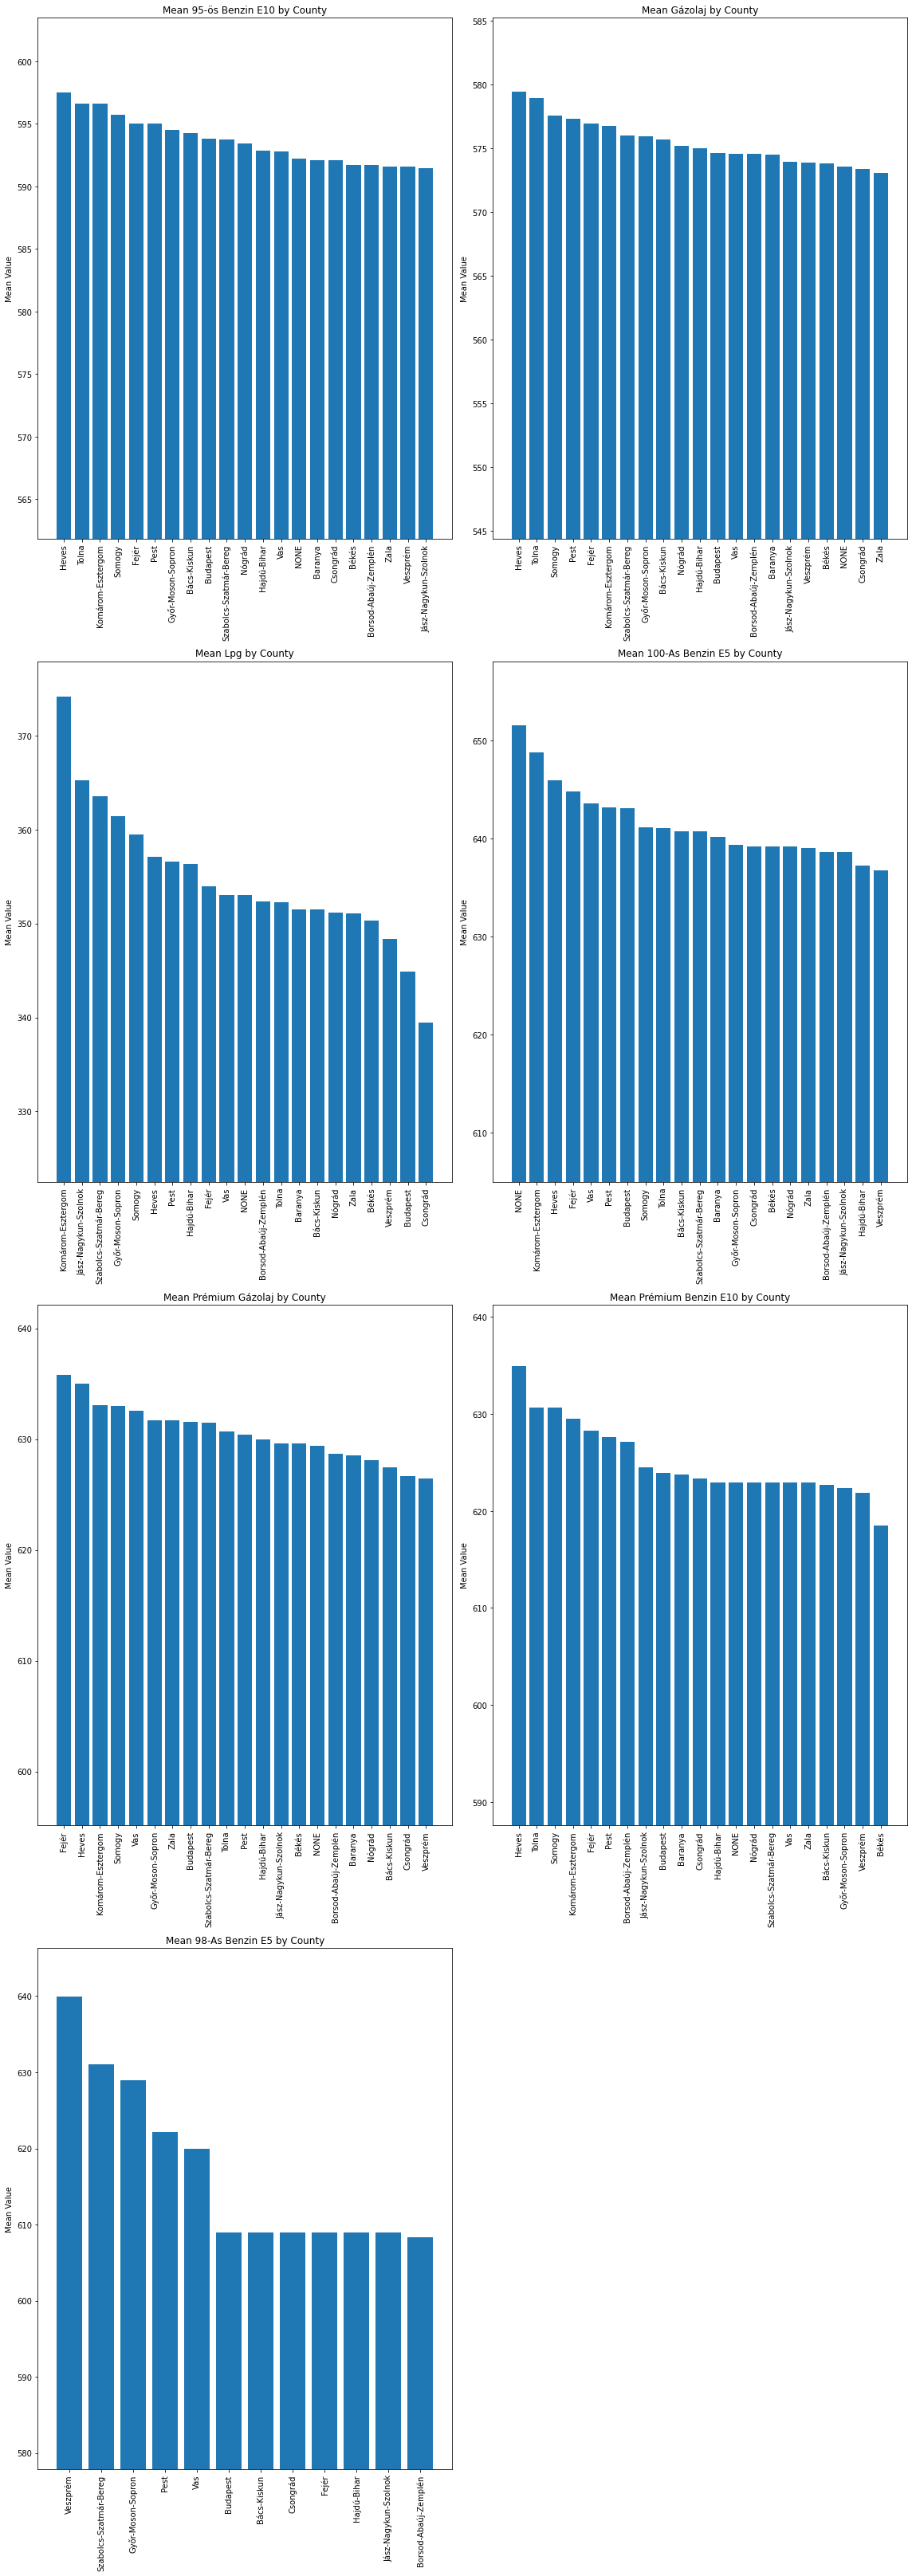

In [30]:
# Group the data by county and calculate the mean of fuel types
fuel_types = ['95-ös Benzin E10', 'Gázolaj', 'Lpg', '100-As Benzin E5', 'Prémium Gázolaj', 'Prémium Benzin E10', '98-As Benzin E5', 'Adblue']
grouped_data = gas_stations.groupby('County')[fuel_types].mean()

# Create a figure with 4 rows and 2 columns
fig, axs = plt.subplots(4, 2, figsize=(16, 45))

# Loop through the fuel types and create a subplot for each
for i, fuel in enumerate(fuel_types):
    # Sort the data in descending order based on the mean of the current fuel type
    sorted_data = grouped_data.sort_values(by=fuel, ascending=False)
    # Calculate the row and column indices of the subplot
    row = i // 2
    col = i % 2
    # Create a bar plot in the current subplot
    x_values = [county.split(' ')[0] for county in sorted_data.index]
    axs[row, col].bar(x_values, sorted_data[fuel])
    # Set the title and y-axis label
    axs[row, col].set_title(f'Mean {fuel} by County')
    axs[row, col].set_ylabel('Mean Value')
    # Rotate the x-axis labels for better readability
    axs[row, col].tick_params(axis='x', rotation=90)
    # Adjust the y-axis limits to remove extra whitespace
    #ymin, ymax = axs[row, col].get_ylim()
    #axs[row, col].set_ylim(ymin*0.95, ymax*1.2)
    
    # Set the y-axis limits
    axs[row, col].set_ylim(sorted_data[fuel].min() * 0.95, sorted_data[fuel].max()*1.01)

# Remove the extra subplot
fig.delaxes(axs[3, 1])

# Adjust the spacing between the subplots
fig.tight_layout()

# Show the plot
plt.show()

In [31]:
comp = ['Number of competition 1km', 'Number of competition 5km', 'Number of competition 10km', 'Number of competition 20km','Number of competition 30km', 'Number of competition 40km']
print('Average number of competitions based on county:')
gas_stations.groupby('County')[comp].mean()

Average number of competitions based on county:


,Number of competition 1km,Number of competition 5km,Number of competition 10km,Number of competition 20km,Number of competition 30km,Number of competition 40km
County,,,,,,
Baranya megye,1.159091,3.545455,8.840909,17.613636,36.386364,60.227273
Borsod-Abaúj-Zemplén megye,2.157143,5.271429,13.257143,25.771429,49.371429,72.442857
Budapest,3.286550,46.269006,134.017544,258.935673,315.578947,348.456140
Bács-Kiskun megye,1.645161,6.956989,9.505376,20.602151,38.075269,70.623656
Békés megye,1.972222,5.250000,7.083333,12.944444,21.444444,40.527778
Csongrád vármegye,2.148148,9.259259,13.425926,26.851852,41.518519,56.629630
Fejér megye,1.076923,10.512821,14.769231,32.410256,64.923077,136.307692
Győr-Moson-Sopron megye,2.200000,10.414286,15.700000,22.471429,38.914286,59.171429
Hajdú-Bihar megye,1.509434,8.188679,9.924528,20.622642,35.886792,60.452830


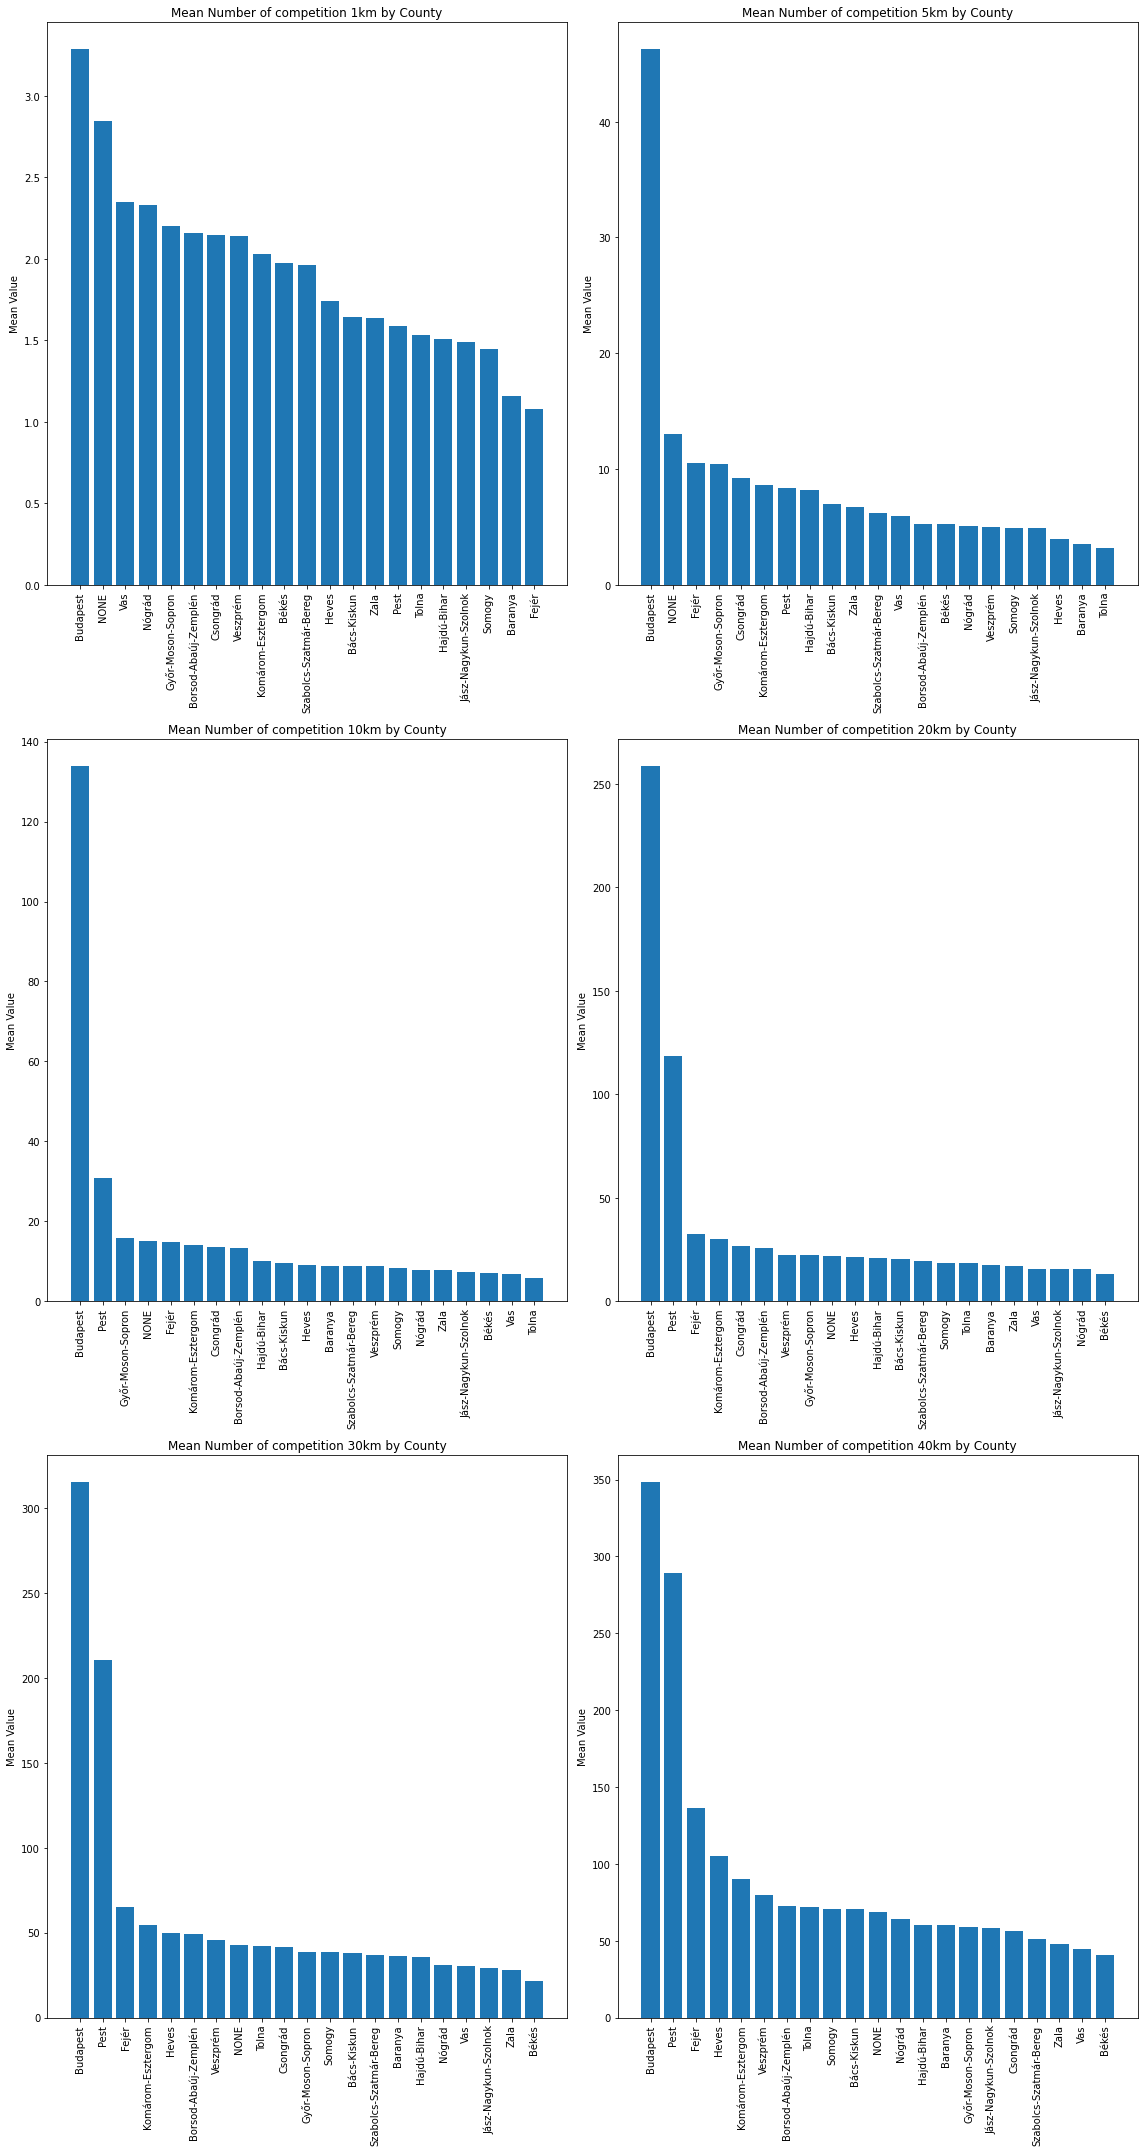

In [32]:
comp = ['Number of competition 1km', 'Number of competition 5km', 'Number of competition 10km', 'Number of competition 20km','Number of competition 30km', 'Number of competition 40km']
grouped_data = gas_stations.groupby('County')[comp].mean()

# Create a figure with 4 rows and 2 columns
fig, axs = plt.subplots(3, 2, figsize=(16, 30))

# Loop through the fuel types and create a subplot for each
for i, fuel in enumerate(comp):
    # Sort the data in descending order based on the mean of the current fuel type
    sorted_data = grouped_data.sort_values(by=fuel, ascending=False)
    # Calculate the row and column indices of the subplot
    row = i // 2
    col = i % 2
    # Create a bar plot in the current subplot
    x_values = [county.split(' ')[0] for county in sorted_data.index]
    axs[row, col].bar(x_values, sorted_data[fuel])
    # Set the title and y-axis label
    axs[row, col].set_title(f'Mean {fuel} by County')
    axs[row, col].set_ylabel('Mean Value')
    # Rotate the x-axis labels for better readability
    axs[row, col].tick_params(axis='x', rotation=90)

# Remove the extra subplot
#fig.delaxes(axs[3, 1])

# Adjust the spacing between the subplots
fig.tight_layout()

# Show the plot
plt.show()

Let's check out that are the categorical values independent from the newly created County variable.

In [33]:
cont_table = pd.crosstab(gas_stations['Franchise (or private)'], gas_stations['County'])

# Perform chi-squared test
chi2, p_value, dof, expected = chi2_contingency(cont_table)

print(f"Chi-square statistic for Franchise and County: {chi2}")
print(f"P-value: {p_value}")

Chi-square statistic for Franchise and County: 245.80714633778535
P-value: 8.294457196752023e-08


The Chi-square statistic of 245.81 is relatively large, and the very small p-value of 8.29e-08 indicates strong evidence against the null hypothesis. Therefore, we can conclude that there is a significant association between Franchise and County.

In [34]:
gas_stations.columns

Index(['Address with post code (Gas Stations)', 'Address', 'City', 'Post Code',
       'Franchise (or private)', 'Highway', 'Link', 'Services',
       'Address from website', '95-ös Benzin E10', 'Gázolaj', 'Lpg',
       '100-As Benzin E5', 'Cng', 'Prémium Gázolaj', 'Prémium Benzin E10',
       '98-As Benzin E5', 'Adblue', 'Type-1 Elektromos Töltő',
       'Type-2 Elektromos Töltő', 'Chademo Elektromos Töltő',
       'Ccs - Elektromos Töltő', 'Number of competition 1km',
       'Number of competition 5km', 'Number of competition 10km',
       'Number of competition 20km', 'Number of competition 30km',
       'Number of competition 40km', 'City_for_merge', 'Housing',
       'Retail stores', 'Unemployed 15-64', 'Allowance',
       'Income tax per person', 'Commuters Abroad', 'N drinking water',
       'Employed 15-64', 'Tax per 1000', 'N of cars per 1000',
       'N of agriculture', 'Commuter Difference', 'Income Tax per Person',
       'Locally Employed', 'County'],
      dtype='object')